In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
# from CNN_model import create_3d_cnn
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization

In [8]:
def extract_frames_from_video(video_path, num_frames=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(length // num_frames, 1)

    frame_count = 0
    saved_count = 0

    while cap.isOpened() and saved_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame = cv2.resize(frame, (112, 112))  # Ensure the frame is resized to (112, 112)
            frames.append(frame)
            saved_count += 1
        frame_count += 1

    cap.release()

    while len(frames) < num_frames:
        frames.append(frames[-1] if frames else np.zeros((112, 112, 3)))  # Handle empty frames case

    return frames

def load_videos_and_labels(dataset_dir):
    print("Loading dataset")
    classes = ['A', 'B']
    X = []
    y = []

    for class_name in classes:
        class_path = os.path.join(dataset_dir, class_name)
        label = 1 if class_name == 'A' else 0

        for video_name in os.listdir(class_path):
            video_path = os.path.join(class_path, video_name)
            frames = extract_frames_from_video(video_path)
            X.append(frames)
            y.append(label)

    return np.array(X), np.array(y)

In [9]:
# Example usage
dataset_dir = 'D:/Muhammad_Saad/Ensemble-learning/testing/'
Videos, Labels = load_videos_and_labels(dataset_dir)

Loading dataset


In [11]:
train_features, test_features, train_labels, test_labels = train_test_split(Videos, Labels, test_size=0.05, random_state=True)
train_labels = to_categorical(train_labels, num_classes=2)

In [12]:
train_features = train_features/255.0

In [13]:
def create_3d_cnn(input_shape):
    model = Sequential()

    model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001), padding='same'))
    model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'))
    model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())

    model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'))
    model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'))
    model.add(Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'))
    model.add(Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dense(units=512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))

    model.add(Dense(units=2, activation='softmax'))  

    return model

# Cluster setup 

In [17]:
import tensorflow as tf

cluster = tf.train.ClusterSpec({
    "worker": [
        "10.127.94.14:2222",
        "10.127.94.33:2222"
    ]
})

In [20]:
$env:TF_CONFIG='{
    "cluster": {
        "worker": [
            "primary_machine_ip:2222",
            "secondary_machine_ip:2222"
        ]
    },
    "task": {"type": "worker", "index": 0}
}'

SyntaxError: unterminated string literal (detected at line 1) (753802657.py, line 1)

In [8]:
input_shape = (30, 112, 112, 3)
optimizer = Adam(learning_rate=0.0001)
batchSize = 8
epochs = 50 
validation_split = 0.2

In [9]:

model = create_3d_cnn(input_shape)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 112, 112, 32)  2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 112, 112, 32)  27680     
                                                                 
 batch_normalization (BatchN  (None, 30, 112, 112, 32)  128      
 ormalization)                                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 30, 112, 112, 64)  55360     
                                                                 
 conv3d_3 (Conv3D)           (None, 30, 112, 112, 64)  110656    
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 56, 56, 64)   0         
 )                                                      

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batchSize,
                    validation_split=validation_split)

Epoch 1/50
186/186 [==============================] - 105s 534ms/step - loss: 3.3627 - accuracy: 0.7305 - val_loss: 3.7575 - val_accuracy: 0.5174 - lr: 1.0000e-04
Epoch 2/50
186/186 [==============================] - 99s 531ms/step - loss: 2.8957 - accuracy: 0.8017 - val_loss: 3.2510 - val_accuracy: 0.5174 - lr: 1.0000e-04
Epoch 3/50
186/186 [==============================] - 100s 535ms/step - loss: 2.5688 - accuracy: 0.8165 - val_loss: 2.6712 - val_accuracy: 0.5174 - lr: 1.0000e-04
Epoch 4/50
 98/186 [==============>...............] - ETA: 43s - loss: 2.3358 - accuracy: 0.8380

NameError: name 'history' is not defined

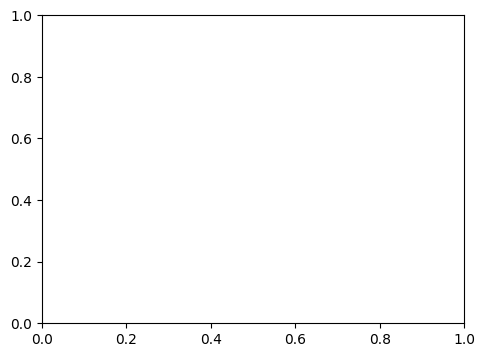

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save("CNN.ipynb")